Libraries imported and their purpose:<br>
 - pyspark : Used as interface for apache spark in python.<br>
 - SparkSession : An entry point to underlying PySpark functionalities to programmatically create PySpark RDD, dataframe.<br>
 - udf : Functions for creating user-defined functions (UDFs) for custom transformations in Spark.<br>
 - StructType, StructField, ArrayType, FloatType, IntegerType : Data types for defining schemas and manipulating structured data in Spark.<br>
 - PIL : Python Imaging Library (PIL) module for image processing tasks such as reading and manipulating images.<br>
 - os : Built-in Python module for interacting with the operating system, such as handling directories and files.<br>
 - pickle : Module for serializing and deserializing Python objects to save and load data efficiently.<br>
 - hdfs : HDFS client for interacting with Hadoop Distributed File System

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType, IntegerType
from PIL import Image  
import os
import pickle 
from hdfs import InsecureClient 

SparkSession is created using SparkSession.builder builder pattern. Application name is "CIFAR-10 Processing".<br>
- Allocated 8 GB memory to each executor for handling large data processing tasks.<br>
- Allocated 8 GB memory to the driver, which coordinates the execution of the application.<br>
- Configured 8 cores for executors to utilize parallel processing effectively.<br>

SparkSession can be monitored using Spark Web UI: http://localhost:4040

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("CIFAR-10 Processing") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executer.cores", "8") \
    .getOrCreate()

HDFS Web UI URL and HDFS directory for CIFAR-10 dataset are mentioned to access images for processing.<br>
- HDFS Web UI can be accessed at: http://localhost:9870

In [3]:
# HDFS Configuration
hdfs_url = "http://localhost:9870"               # HDFS Namenode web UI address
hdfs_path = "/user/hdoop/cifar10_images/"        # HDFS directory for CIFAR-10 dataset
client = InsecureClient(hdfs_url, user='hdoop')  # HDFS client for file operations

Defined CIFAR-10 batch file loader to read the binary data from HDFS.<br>
- This function is designed to load CIFAR-10 batch file from HDFS.<br>
- Each batch contains image data and corresponding labels stored in binary format.<br>

Reshaped and normalized images by dividing pixel values by 255 scales the pixel intensity values (originally in the range [0, 255]) to the range [0, 1] has below benefits:<br>
- Improves model training<br>
- Reduces Numerical Instability<br>
- Standard practice for compatibility<br>

In [4]:
# Defined CIFAR-10 batch file loader
def load_cifar10_batch(hdfs_path):
    # Read binary data from HDFS
    with client.read(hdfs_path) as f:
        data_dict = pickle.load(f, encoding='bytes') # Deserialized the binary content
        images = data_dict[b'data']    # Image data
        labels = data_dict[b'labels']  # Corresponding Labels
        
        # Reshaped the image data to the expected format (32x32 RGB images) and normalized
        images = images.reshape(len(images), 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
        return images, labels

Loaded and combined all CIFAR-10 batches from HDFS using above defined batch file loader function.<br>
- The CIFAR-10 dataset is divided into 5 training batches.<br>
- Each batch file is read from HDFS, processed, and its images and labels are combined into a single list.<br>

By executing below loop, got all training images and their corresponding labels into "all_images" and "all_labels" respectively.

In [5]:
# Loaded and combined all CIFAR-10 batches from HDFS
batch_files = [f"{hdfs_path}data_batch_{i}" for i in range(1, 6)]

# Initialized empty lists to hold all images and labels
all_images=[]
all_labels=[]

# Looped through each batch file and process its content
for batch_file in batch_files:

    # Loaded images and labels data from the current batch file
    images, labels = load_cifar10_batch(batch_file)

    all_images.extend(images) # Added images from the current batch
    all_labels.extend(labels) # Added labels from the current batch

 Defined a schema suitable for flattened image data.<br>
- This schema is used to structure the data when converting it to a Spark DataFrame.<br>
- Column name and type are defined for the image data and its corresponding label as below:<br>
    - For Image field:<br>
        - ArrayType(FloatType()): Represents the flattened image data as an array of floating-point numbers.<br>
        - True: This field is nullable, allowing for potential missing values (if any).<br>
    - For Label field:<br>
        - IntegerType(): Represents the label as an integer (e.g., 0–9 for CIFAR-10 classes).<br>
        - True: This field is also nullable.<br>

In [6]:
# Defined a schema suitable for flattened image data
schema = StructType([
    StructField("Image", ArrayType(FloatType()), True),  
    StructField("Label", IntegerType(), True)            
])
"""
The "Image" field stores normalized pixel values from a flattened 32x32x3 image (total 3072 values per image).
The "Label" field stores the class label, with CIFAR-10 having 10 classes (values range from 0 to 9).
This schema is designed for compatibility with Spark DataFrames, enabling distributed processing of image data.
"""

'\nThe "Image" field stores normalized pixel values from a flattened 32x32x3 image (total 3072 values per image).\nThe "Label" field stores the class label, with CIFAR-10 having 10 classes (values range from 0 to 9).\nThis schema is designed for compatibility with Spark DataFrames, enabling distributed processing of image data.\n'

Each batch is processed by combining the images and labels lists (or arrays) element-wise into pairs (tuples). Thus each element in the resulting object is a tuple (image, label). parallelize function converts the zipped list of (image, label) tuples into an RDD (Resilient Distributed Dataset), distributing the data across the Spark cluster.

In [7]:
# Processed and converted each batch to a DataFrame one at a time
for batch_idx, batch_file in enumerate(batch_files):
    # Loaded images and labels from HDFS for the current batch
    images, labels = load_cifar10_batch(batch_file)

    # Created zipped list of (images, labels) tuples and converted it into an RDD 
    rdd = spark.sparkContext.parallelize(zip(images, labels))

    # Flattened images during the RDD map transformation
    rdd = rdd.map(lambda x: (x[0].flatten().tolist(), x[1]))    

    # Created a Spark DataFrame for the current batch
    batch_df = spark.createDataFrame(rdd, schema=schema)

    # Repartitioned data into smaller chunks to avoid large task sizes
    batch_df = batch_df.repartition(10)
    
    # Set the maximum number of records (rows) written to a single output file
    spark.conf.set("spark.sql.files.maxRecordsPerFile", 500)

    # Created the partitions and stored it into HDFS for later use)
    batch_df.write.mode('append').parquet(f"{hdfs_path}/cifar10_train_batches") 
    print(f"Processed and saved batch {batch_idx + 1}")

24/12/03 00:20:51 WARN TaskSetManager: Stage 0 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


Processed and saved batch 1


24/12/03 00:21:06 WARN TaskSetManager: Stage 3 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


Processed and saved batch 2


24/12/03 00:21:17 WARN TaskSetManager: Stage 6 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


Processed and saved batch 3


24/12/03 00:21:28 WARN TaskSetManager: Stage 9 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


Processed and saved batch 4


24/12/03 00:21:39 WARN TaskSetManager: Stage 12 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


Processed and saved batch 5


In [8]:
batch_df.rdd.getNumPartitions() # Get the number of partitions in the RDD (Resilient Distributed Dataset) for the DataFrame

24/12/03 00:22:09 WARN TaskSetManager: Stage 15 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


10

In [9]:
batch_df.show() # Display the first few rows of the DataFrame

24/12/03 00:22:23 WARN TaskSetManager: Stage 16 contains a task of very large size (12339 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+
|               Image|Label|
+--------------------+-----+
|[0.2509804, 0.207...|    8|
|[0.29803923, 0.48...|    8|
|[0.19215687, 0.25...|    4|
|[0.6862745, 0.709...|    3|
|[1.0, 1.0, 1.0, 1...|    7|
|[0.21176471, 0.34...|    1|
|[0.83137256, 0.76...|    7|
|[0.13333334, 0.15...|    2|
|[0.39215687, 0.42...|    6|
|[0.5411765, 0.552...|    4|
|[0.17254902, 0.35...|    0|
|[0.6862745, 0.686...|    7|
|[0.36862746, 0.52...|    8|
|[0.9137255, 0.913...|    8|
|[0.45490196, 0.27...|    5|
|[0.84313726, 0.85...|    0|
|[0.6784314, 0.490...|    6|
|[1.0, 1.0, 1.0, 0...|    3|
|[0.47058824, 0.54...|    4|
|[0.54901963, 0.39...|    3|
+--------------------+-----+
only showing top 20 rows



Libraries imported and their purpose:<br>
- tensorflow : For building and training machine learning and deep learning models.<br>
- numpy : For numerical computations and handling arrays<br>
- matplotlib : This is used for visualization purpose<br>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Load Parquet data from HDFS
parquet_path = f"{hdfs_path}/cifar10_train_batches" # Define the HDFS path to the Parquet files
train_df = spark.read.parquet(parquet_path)  # Read the Parquet files into a Spark DataFrame

In [12]:
train_df.show() # Display the first few rows of the DataFrame to verify the loaded training data

+--------------------+-----+
|               Image|Label|
+--------------------+-----+
|[0.6431373, 0.435...|    3|
|[0.87058824, 0.91...|    1|
|[0.6784314, 0.713...|    7|
|[0.3882353, 0.105...|    3|
|[1.0, 1.0, 1.0, 0...|    6|
|[0.27058825, 0.32...|    9|
|[1.0, 1.0, 1.0, 0...|    1|
|[0.78039217, 0.84...|    6|
|[0.6156863, 0.556...|    2|
|[0.105882354, 0.1...|    3|
|[0.5686275, 0.584...|    4|
|[0.22745098, 0.27...|    2|
|[0.8156863, 0.819...|    0|
|[0.56078434, 0.48...|    3|
|[0.78039217, 0.61...|    2|
|[0.7372549, 0.776...|    6|
|[0.64705884, 0.63...|    5|
|[0.47843137, 0.6,...|    8|
|[0.9019608, 0.909...|    9|
|[0.11764706, 0.12...|    1|
+--------------------+-----+
only showing top 20 rows



Here Spark DataFrames are converted to NumPy arrays as TensorFlow requires data in NumPy array or Tensor format for its operations. This is a simple solution for CIFAR-10 dataset.

In [ ]:
# Spark DataFrames are converted to NumPy arrays as TensorFlow requires data in NumPy array or Tensor format for its operations. 
images = []
labels = []

# Iterate through each row of the Spark DataFrame
for row in train_df.toLocalIterator():
    images.append(np.array(row["Image"]).reshape(32, 32, 3))
    labels.append(row["Label"])

# Convert the lists to NumPy arrays for TensorFlow compatibility
images = np.array(images)
labels = np.array(labels)

In [13]:
# Converted labels to one-hot encoded vectors for using in machine learning models, specially neural networks
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=10)

In [16]:
# Splitted the dataset into training and testing images
split_index = int(0.8 * len(images))
train_images, test_images = images[:split_index], images[split_index:]
train_labels, test_labels = labels_one_hot[:split_index], labels_one_hot[split_index:]

In [17]:
# Created TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(20)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(20)

2024-12-03 00:23:38.592028: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98304000 exceeds 10% of free system memory.


Defined the TensorFlow Keras model for image classification task. Different layers are created for model to learn complex patterns in the images. Additionally below activation functions are used:<br>
- relu : Introduces non-linearity and helps the network learn complex patterns<br>
- softmax : Used for multi-class classification problems<br>

In [ ]:
# Defined the TensorFlow Keras model
model = tf.keras.Sequential([
    # Added input layer where iamge Height = 32 pixels, Width = 32 pixels, Channels = 3 (for RGB color images)
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),        


    # Added first convolutional layer
    # number of filters = 32 (Each filter learns a unique pattern), Filter size = (3,3)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),   
    tf.keras.layers.MaxPooling2D((2, 2)), 

    # Added second convolutional layer to Learn more complex patterns
    # number of filters = 64                   
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),   

    # Converted the 3D feature maps into a 1D vector to feed into the fully connected layers
    tf.keras.layers.Flatten(),

    # Applied dense connections to learn relationships between features having 64 neurons
    tf.keras.layers.Dense(64, activation='relu'),

    # Added number of classes = 10 and used softmax function to convert raw output scores (logits) into a probability distribution across classes
    tf.keras.layers.Dense(10, activation='softmax')
])

/home/hdoop/tensorflow_env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


The model is compiled using compile() method that configures the model with the necessary components, including the optimizer, loss function, and metrics as below:<br>
- optimizer = adam :<br> 
    - It determines how the model’s weights (parameters) are updated during training.<br>
- loss = categorical_crossentropy :<br> 
    - The function computes the difference between the predicted probability distribution (from the softmax output) and the actual class distribution (one-hot encoded).<br>
    - It measures how well or poorly the model is performing.<br>
- metrics = accuracy :<br> 
    - It is used to evaluate the performance of the model during training and testing.<br> 
    - It measures the proportion of correct predictions out of all predictions made

In [19]:
# Compiled the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch: One epoch means that every sample in the training dataset has been seen and used once by the model. When a model is trained for multiple epochs, the model will repeatedly look at the training data, adjust its weights based on the loss, and update its parameters.<br>

Here, epochs=10 means that the model will go through the training data 10 times. After each epoch, the model's parameters (weights) will be updated based on the computed loss and optimizer settings.

In [20]:
# Trained the model
model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


2024-12-03 00:23:53.956260: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98304000 exceeds 10% of free system memory.


400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2265 - loss: 2.0445 - val_accuracy: 0.4170 - val_loss: 1.5896
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4244 - loss: 1.5821 - val_accuracy: 0.4470 - val_loss: 1.4963
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5040 - loss: 1.4062 - val_accuracy: 0.4865 - val_loss: 1.4232
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5433 - loss: 1.2759 - val_accuracy: 0.4995 - val_loss: 1.4444
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5744 - loss: 1.1773 - val_accuracy: 0.5220 - val_loss: 1.3873
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6247 - loss: 1.0677 - val_accuracy: 0.5120 - val_loss: 1.4429
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6533 - loss: 0.9739 - val_accuracy: 0.4855 - val_loss: 1.6749
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6823 - loss: 0.9033 - val_accuracy: 0.476

Model is evaluated by using model.evaluate() method. This method evaluates the trained model on the test dataset by calculating the loss and the metrics (such as accuracy)
- First accuracy value = 0.6000: This is the training accuracy during the first batch of the first epoch.
- Second accuracy value = 0.5996: This is the training accuracy after one epoch, calculated as the average accuracy across all batches in that epoch.
- Test accuracy = 0.597100019454956: This is the accuracy on the test dataset after the training is complete. It is usually lower than the training accuracy because the test data is unseen and represents the model's generalization ability.

In [25]:
# Evaluated the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4000 - loss: 2.2927

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4673 - loss: 1.8530
Test Accuracy: 0.4779999852180481


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2024-12-03 00:17:26.300430: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


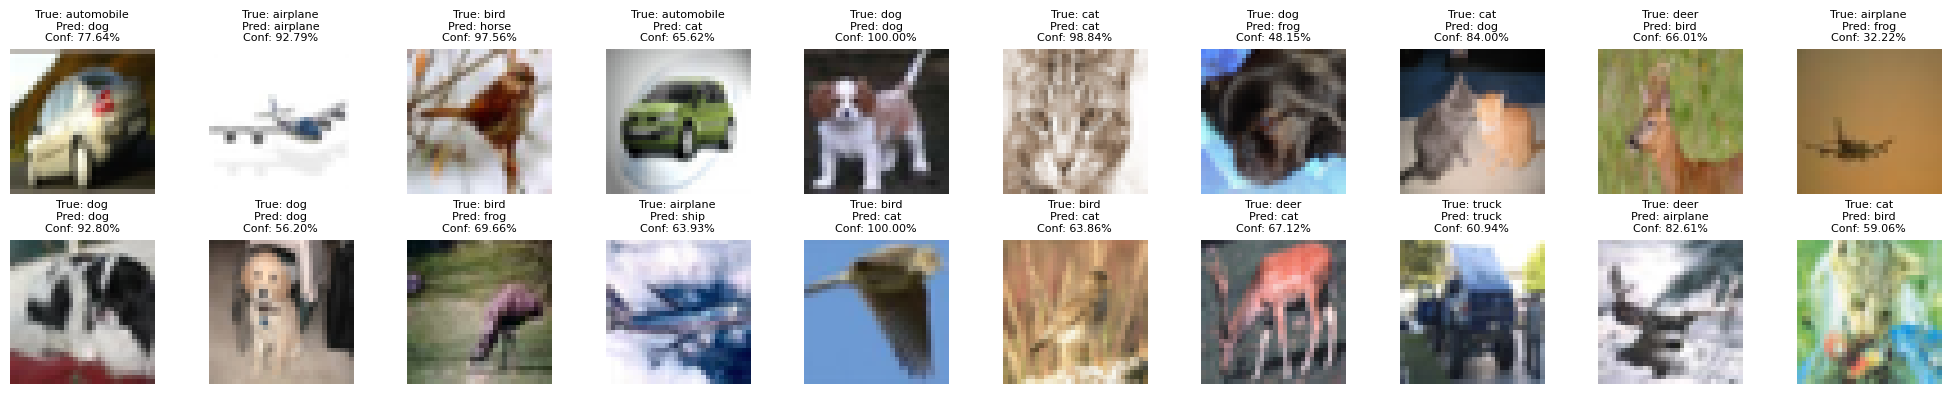

In [25]:
def visualize_predictions(dataset, model, num_images=20, grid_size=(2, 10)):
    """
    Visualize predictions from the model on a dataset.
    
    Args:
        dataset (tf.data.Dataset): TensorFlow dataset to evaluate.
        model (tf.keras.Model): Trained TensorFlow model to make predictions.
        num_images (int): Number of images to visualize. Default is 5.
        class_names (list of str): Class names corresponding to labels. Default is None.
    """
    # Defined class names for CIFAR-10 dataset
    class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    # Determined the number of rows and columns for the grid
    rows, cols = grid_size
    plt.figure(figsize=(cols * 2, rows * 2))  
    
    for batch in dataset.take(1):
        images, labels = batch
        predictions = model.predict(images)

        # Ensured we don't try to display more images than the batch size
        num_images_to_display = min(num_images, len(images))

        for i in range(num_images_to_display):
            # Get the row and column for the image position in the grid
            row = i // cols
            col = i % cols
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy())  # Ensure the image is in a viewable format
            
            # Converted numeric labels to class names
            true_label = class_names[np.argmax(labels[i])]
            predicted_label = class_names[np.argmax(predictions[i])]
            confidence = np.max(predictions[i]) * 100
            
            # Added the title with prediction details
            plt.title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=8)
            plt.axis('off')  # Hide axes for better visual

    plt.tight_layout()  # Adjusted layout to avoid overlap
    plt.show()

# Called visualization function
visualize_predictions(test_dataset, model)
